# Notebook Initialization

In [11]:
# %load nb_init.py

from pathlib import Path
import pandas as pd

base_dir = Path.cwd().parent
config_dir = base_dir / "config"
data_dir = base_dir / "data"
docs_dir = base_dir / "docs"
figures_dir = docs_dir / "figures"
models_dir = base_dir / "models"
logs_dir = base_dir / "logs"
images_input_dir = data_dir / "COVID19"
images_pp_dir = data_dir / "COVID19-preprocessed"
preprocessed_dir = data_dir / "preprocessed"
output_dir = data_dir / "output"

# Directories used to train the CNN (image by image) 
cnn_data_dir = data_dir / "modelling" / "cnn"
cnn_train_dir = cnn_data_dir / "train"
cnn_test_dir = cnn_data_dir / "test"

metadata_file = images_input_dir / "metadata.csv"
labels_file = images_input_dir / "unzip_filenames.csv"
preprocessed_labels_file = preprocessed_dir / "labels.parquet"

feature_extractor_model_file = models_dir / "feature_extractor.tf"

from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark = SparkSession.builder.getOrCreate()

config_file = config_dir / "tfg.conf"

from pyhocon import ConfigFactory
config = None

def load_config():
    return ConfigFactory.parse_file(config_file)

config = load_config()
    
import sys

if str(base_dir / "src") not in sys.path:
    sys.path.append(str(base_dir / "src"))

%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
spark

In [3]:
from tfg import DataRepository

repo = DataRepository(config=config, base_data_path=data_dir)

# Load Datasets

In [4]:
train_df = repo.load("train_df")
train_df.head(5)

,label,file,patient_id,scan_id,n_slice,num_clips,seq_num,clip_num
0,CP,CP/0/3131/0275.png,0,3131,285,0,0,0
1,CP,CP/0/3131/0064.png,0,3131,285,0,1,0
2,CP,CP/0/3131/0083.png,0,3131,285,0,2,0
3,CP,CP/0/3131/0160.png,0,3131,285,0,3,0
4,CP,CP/0/3131/0127.png,0,3131,285,0,4,0


In [5]:
val_df = repo.load("val_df")
val_df.head(5)

,label,file,patient_id,scan_id,n_slice,num_clips,seq_num,clip_num
0,CP,CP/1075/3118/0543.jpg,1075,3118,553,1075,0,0
1,CP,CP/1075/3118/0174.jpg,1075,3118,553,1075,1,0
2,CP,CP/1075/3118/0130.jpg,1075,3118,553,1075,2,0
3,CP,CP/1075/3118/0525.jpg,1075,3118,553,1075,3,0
4,CP,CP/1075/3118/0152.jpg,1075,3118,553,1075,4,0


# Data Generators

In [6]:
from keras_preprocessing.image import ImageDataGenerator

In [15]:
img_size = config.get_int("tfg.training.img_size")
image_target_size = (img_size, img_size)
seed = config.get_int("tfg.seed")
val_fraction = config.get_float("tfg.training.val_fraction")
batch_size = config.get_int("tfg.training.batch_size")
rotation_range = config.get_int("tfg.training.rotation_range", 0)
zoom_range = config.get("tfg.training.zoom_range", 1.)

In [17]:
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=rotation_range,
    zoom_range=zoom_range
)
test_datagen = ImageDataGenerator(
    rescale=1./255.,
)

In [18]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=str(images_input_dir),
    x_col="file",
    y_col="label",
    subset="training",
    batch_size=batch_size,
    seed=seed,
    shuffle=True,
    class_mode="categorical",
    target_size=image_target_size)

valid_generator = test_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=str(images_input_dir),
    x_col="file",
    y_col="label",
    batch_size=batch_size,
    seed=seed,
    shuffle=True,
    class_mode="categorical",
    target_size=image_target_size)

Found 331286 validated image filenames belonging to 3 classes.
Found 39828 validated image filenames belonging to 3 classes.


# Create model

In [19]:
import tensorflow as tf

tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [20]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers as reg
from tensorflow.keras import callbacks

In [21]:
input_images = keras.Input(shape=(img_size, img_size, 3), name="input_images")

In [24]:
filters = 6
initial_dense_features = 64
num_features = 32
num_classes = 3
num_layers = 0
cnn_net = input_images

cnn_net = layers.Conv2D(filters=filters, kernel_size=3, padding="same", activation="relu", name=f"conv2d_{num_layers+1:02d}")(cnn_net)
cnn_net = layers.MaxPool2D(2, name=f"maxpool2d_{num_layers+1:02d}")(cnn_net)
filters = filters * 2
num_layers = num_layers + 1

cnn_net = layers.Conv2D(filters=filters, kernel_size=3, padding="same", activation="relu", name=f"conv2d_{num_layers+1:02d}")(cnn_net)
cnn_net = layers.MaxPool2D(2, name=f"maxpool2d_{num_layers+1:02d}")(cnn_net)
filters = filters * 2
num_layers = num_layers + 1

cnn_net = layers.Conv2D(filters=filters, kernel_size=3, padding="same", activation="relu", name=f"conv2d_{num_layers+1:02d}")(cnn_net)
cnn_net = layers.MaxPool2D(2, name=f"maxpool2d_{num_layers+1:02d}")(cnn_net)
filters = filters * 2
num_layers = num_layers + 1

cnn_net = layers.Conv2D(filters=filters, kernel_size=3, padding="same", activation="relu", name=f"conv2d_{num_layers+1:02d}")(cnn_net)
cnn_net = layers.MaxPool2D(2, name=f"maxpool2d_{num_layers+1:02d}")(cnn_net)
filters = filters * 2
num_layers = num_layers + 1

cnn_net = layers.Conv2D(filters=filters, kernel_size=3, padding="same", activation="relu", name=f"conv2d_{num_layers+1:02d}", kernel_regularizer=reg.l2(l=0.01))(cnn_net)
cnn_net = layers.Dropout(0.3, name=f"dropout__{num_layers+1:02d}")(cnn_net)
cnn_net = layers.MaxPool2D(2, name=f"maxpool2d_{num_layers+1:02d}")(cnn_net)
filters = filters * 2
num_layers = num_layers + 1

# cnn_net = layers.Conv2D(filters=filters, kernel_size=3, padding="same", activation="relu", name=f"conv2d_{num_layers+1:02d}", kernel_regularizer=reg.l2(l=0.01))(cnn_net)
# cnn_net = layers.Dropout(0.3, name=f"dropout__{num_layers+1:02d}")(cnn_net)
# cnn_net = layers.MaxPool2D(2, name=f"maxpool2d_{num_layers+1:02d}")(cnn_net)
# filters = filters * 2
# num_layers = num_layers + 1

# cnn_net = layers.Conv2D(filters=filters, kernel_size=3, padding="same", activation="relu", name=f"conv2d_{num_layers+1:02d}", kernel_regularizer=reg.l2(l=0.01))(cnn_net)
# cnn_net = layers.MaxPool2D(2, name=f"maxpool2d_{num_layers+1:02d}")(cnn_net)
# num_layers = num_layers + 1

cnn_net = layers.Flatten(name=f"flatten")(cnn_net)

# cnn_net = layers.Dense(initial_dense_features, activation="relu", name="dense_01")(cnn_net)
# cnn_net = layers.Dropout(0.2, name="dropout_01")(cnn_net)

cnn_net = layers.Dense(initial_dense_features, activation="relu", name="dense_01")(cnn_net)
cnn_net = layers.Dropout(0.5, name="dropout_01")(cnn_net)


cnn_net = layers.Dense(num_features, activation="relu", name="dense_02")(cnn_net)
cnn_net = layers.Dropout(0.5, name="dropout_02")(cnn_net)

output_layer = layers.Dense(num_classes, activation="softmax", name="output")
outputs = output_layer(cnn_net)

model = keras.Model(inputs=input_images, outputs=outputs, name="covid_classifier")
model.summary()

Model: "covid_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_images (InputLayer)    [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_01 (Conv2D)           (None, 128, 128, 6)       168       
_________________________________________________________________
maxpool2d_01 (MaxPooling2D)  (None, 64, 64, 6)         0         
_________________________________________________________________
conv2d_02 (Conv2D)           (None, 64, 64, 12)        660       
_________________________________________________________________
maxpool2d_02 (MaxPooling2D)  (None, 32, 32, 12)        0         
_________________________________________________________________
conv2d_03 (Conv2D)           (None, 32, 32, 24)        2616      
_________________________________________________________________
maxpool2d_03 (MaxPooling2D)  (None, 16, 16, 24)   

In [25]:
model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['categorical_accuracy'])

In [26]:
train_generator.n // train_generator.batch_size

10352

In [27]:
num_models = 1
cnn_model_suffix = f"{num_models:02d}"
cnn_model_dir = models_dir / f"cnn_{cnn_model_suffix}"

while cnn_model_dir.exists():
    num_models += 1
    cnn_model_suffix = f"{num_models:02d}"
    cnn_model_dir = models_dir / f"cnn_{cnn_model_suffix}"

print(f"CNN Model dir: {cnn_model_dir}")
cnn_model_dir.mkdir(exist_ok=True)
cnn_checkpoint_dir = cnn_model_dir / "checkpoint"
cnn_checkpoint_dir.mkdir(exist_ok=True)

cnn_logs_dir = logs_dir / f"cnn_{cnn_model_suffix}"
cnn_logs_dir.mkdir()

CNN Model dir: /home/albert/projects/tfg/models/cnn_06


In [28]:
checkpointer = callbacks.ModelCheckpoint(
    str(cnn_checkpoint_dir),
    monitor="val_categorical_accuracy",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch"
)

tensorboard_logger = callbacks.TensorBoard(
    log_dir=str(cnn_logs_dir),
    histogram_freq=1,
    write_graph=False,
    write_images=False,
    update_freq='epoch',
    profile_batch=2,
    embeddings_freq=0,
    embeddings_metadata=None
)

model_callbacks = [checkpointer, tensorboard_logger]
#model_callbacks = [checkpointer]

In [29]:
# The total passes we want to do over the whole dataset
total_epochs = 10
# For each pass, how many times do we want to check the performance on the validation data?
intermediate_checks = 5
epochs = total_epochs * intermediate_checks

# If in total we need e.g. 1000 steps to go through the whole dataset, and we want to check 2 times the validation, each epoch will be 500 steps instead
STEP_SIZE_TRAIN=train_generator.n//(intermediate_checks * train_generator.batch_size) 
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
#STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

fit_history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs,
                    callbacks=model_callbacks
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
2070/2070 [==============================] - ETA: 0s - loss: 0.7944 - categorical_accuracy: 0.6714
Epoch 00001: val_categorical_accuracy improved from -inf to 0.70888, saving model to /home/albert/projects/tfg/models/cnn_06/checkpoint
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /home/albert/projects/tfg/models/cnn_06/checkpoint/assets
2070/2070 [==============================] - 2241s 1s/step - loss: 0.7944 - categorical_accuracy: 0.6714 - val_loss: 0.7091 - val_categorical_accuracy: 0.7089
Epoch 2/50
2070/2070 [==============================] - ETA: 0s - loss: 0.5761 - categorical_accuracy: 0.7870
Epoch 00002: val_categorical_accuracy improved from 0.70888 to 0.78675, saving model to /home/albert/projects/tfg/models/cnn_06/checkpoint
INFO:tensorflow:Assets written to: /home/albert/projects/tfg/models/cnn_06/checkpoint/assets
207

In [30]:
fit_history.history

{'loss': [0.7943652272224426,
  0.5760934352874756,
  0.5286014676094055,
  0.5018553137779236,
  0.47101083397865295,
  0.45255792140960693,
  0.4326125681400299,
  0.4233097434043884,
  0.42053917050361633,
  0.40687867999076843,
  0.3993310332298279,
  0.38664373755455017,
  0.3816133439540863,
  0.3769403398036957,
  0.36443474888801575,
  0.36331433057785034,
  0.3626139760017395,
  0.36008501052856445,
  0.3522544503211975,
  0.35142913460731506,
  0.3456553816795349,
  0.3384780287742615,
  0.3458242416381836,
  0.33693602681159973,
  0.3338344395160675,
  0.33436158299446106,
  0.3274572491645813,
  0.32962435483932495,
  0.3280717134475708,
  0.32720428705215454,
  0.32387569546699524,
  0.3209180235862732,
  0.3201245069503784,
  0.3278385400772095,
  0.3164081573486328,
  0.3140355050563812,
  0.31601855158805847,
  0.3132837414741516,
  0.3146933913230896,
  0.3085278868675232,
  0.3160960078239441,
  0.30815690755844116,
  0.31144919991493225,
  0.3138459324836731,
  0.306

In [31]:
import seaborn as sns

sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(13, 9)})

Saving figures to /home/albert/projects/tfg/docs/figures/cnn_06_loss.png


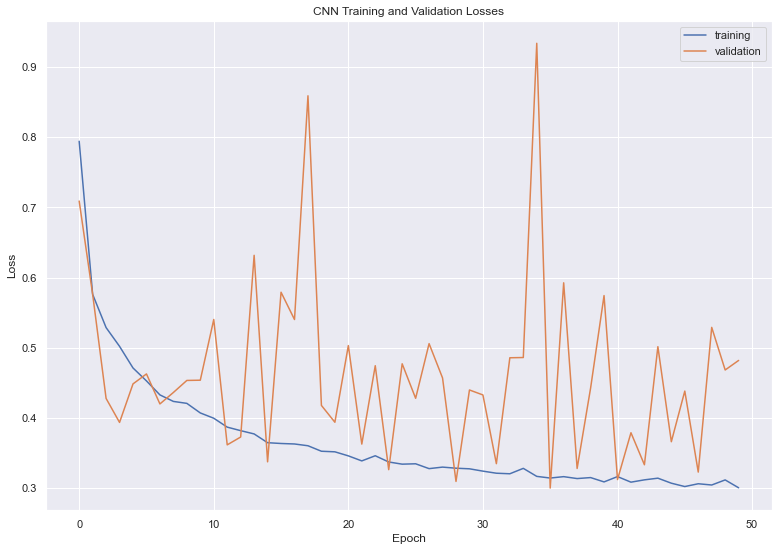

In [32]:
import matplotlib.pyplot as plt

fig_file = figures_dir / f"cnn_{cnn_model_suffix}_loss.png"
print(f"Saving figures to {fig_file}")
plt.plot(fit_history.history["loss"], label="training")
plt.plot(fit_history.history["val_loss"], label="validation")
plt.title("CNN Training and Validation Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig(str(fig_file))
plt.show()

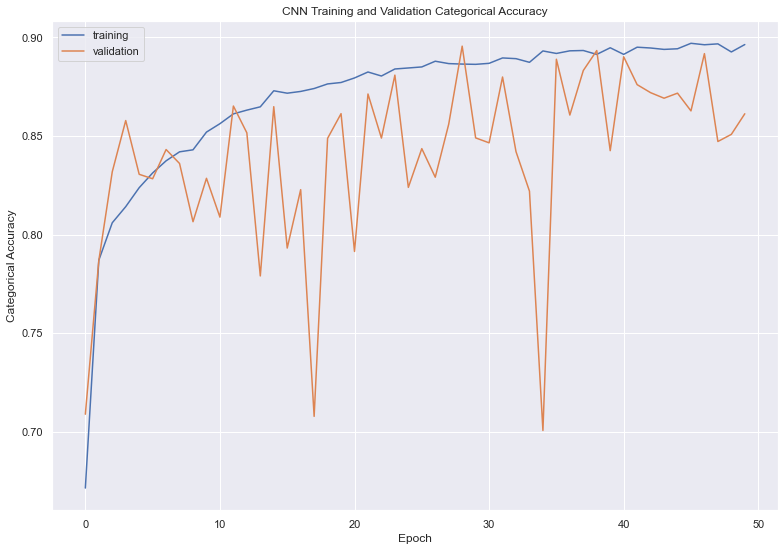

In [33]:
import matplotlib.pyplot as plt

plt.plot(fit_history.history["categorical_accuracy"], label="training")
plt.plot(fit_history.history["val_categorical_accuracy"], label="validation")
plt.title("CNN Training and Validation Categorical Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Categorical Accuracy")
plt.legend()
plt.savefig(figures_dir / f"cnn_{cnn_model_suffix}_cat_accuracy.png")
plt.show()

In [34]:
feature_extractor_model_file

PosixPath('/home/albert/projects/tfg/models/feature_extractor.tf')

In [36]:
#model_file = feature_extractor_model_file
model_file = models_dir / f"feature_extractor_{cnn_model_suffix}.tf"
model.save(str(model_file))

del model

INFO:tensorflow:Assets written to: /home/albert/projects/tfg/models/feature_extractor_06.tf/assets


In [37]:
from tensorflow.keras.models import load_model

loaded_model = load_model(str(model_file))

loaded_model.summary()

Model: "covid_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_images (InputLayer)    [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_01 (Conv2D)           (None, 128, 128, 6)       168       
_________________________________________________________________
maxpool2d_01 (MaxPooling2D)  (None, 64, 64, 6)         0         
_________________________________________________________________
conv2d_02 (Conv2D)           (None, 64, 64, 12)        660       
_________________________________________________________________
maxpool2d_02 (MaxPooling2D)  (None, 32, 32, 12)        0         
_________________________________________________________________
conv2d_03 (Conv2D)           (None, 32, 32, 24)        2616      
_________________________________________________________________
maxpool2d_03 (MaxPooling2D)  (None, 16, 16, 24)   

In [38]:
valid_generator2 = test_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=str(images_input_dir),
    x_col="file",
    y_col="label",
    batch_size=batch_size,
    seed=seed,
    shuffle=False,
    class_mode="categorical",
    target_size=image_target_size)

Found 39828 validated image filenames belonging to 3 classes.


# Evaluation / Confusion matrix

In [39]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

In [40]:
import numpy as np
import itertools

sns.set_style("whitegrid", {'axes.grid' : False})

# based on answer from https://datascience.stackexchange.com/questions/40067/confusion-matrix-three-classes-python
def plot_confusion_matrix(cm, classes,
                          save_to=None,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontdict={'fontsize' : 26})
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=18)
    plt.yticks(tick_marks, classes, fontsize=18)

    fmt_pct = lambda pct: f"{100 * pct:.2f}%" if normalize else f"{int(100 * pct)}%"
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, fmt_pct(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontdict={'fontsize' : 16})

    plt.ylabel('True label', fontdict={'fontsize' : 22})
    plt.xlabel('Predicted label', fontdict={'fontsize' : 22})
    plt.tight_layout()
    
    if save_to:
        plt.savefig(save_to)

In [41]:
STEP_SIZE_TRAIN2=train_generator.n//train_generator.batch_size 
STEP_SIZE_VALID2=valid_generator.n//valid_generator.batch_size

## Validation set

In [42]:
raw_val_preds = loaded_model.predict(valid_generator2, steps=STEP_SIZE_VALID2 + 1, verbose=1)
raw_val_preds.shape

1245/1245 [==============================] - 119s 95ms/step


(39828, 3)

In [43]:
raw_val_preds[:5]

array([[9.7728568e-01, 2.1649901e-02, 1.0643448e-03],
       [9.9986041e-01, 1.3008255e-04, 9.5421474e-06],
       [9.9993885e-01, 6.0918377e-05, 2.7491285e-07],
       [9.9522215e-01, 4.2544077e-03, 5.2343111e-04],
       [9.9987578e-01, 1.2230795e-04, 1.8552662e-06]], dtype=float32)

In [44]:
val_preds = raw_val_preds.argmax(axis=1)
val_preds[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [45]:
valid_generator2.class_indices

{'CP': 0, 'NCP': 1, 'Normal': 2}

In [46]:
val_true = valid_generator2.labels

In [47]:
val_true[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [48]:
val_cm = confusion_matrix(val_true, val_preds)

In [49]:
class_labels = [k for k in valid_generator2.class_indices.keys()]

Normalized confusion matrix
[[0.88810242 0.05040931 0.06148827]
 [0.05837134 0.87420195 0.06742671]
 [0.09452071 0.12112745 0.78435184]]


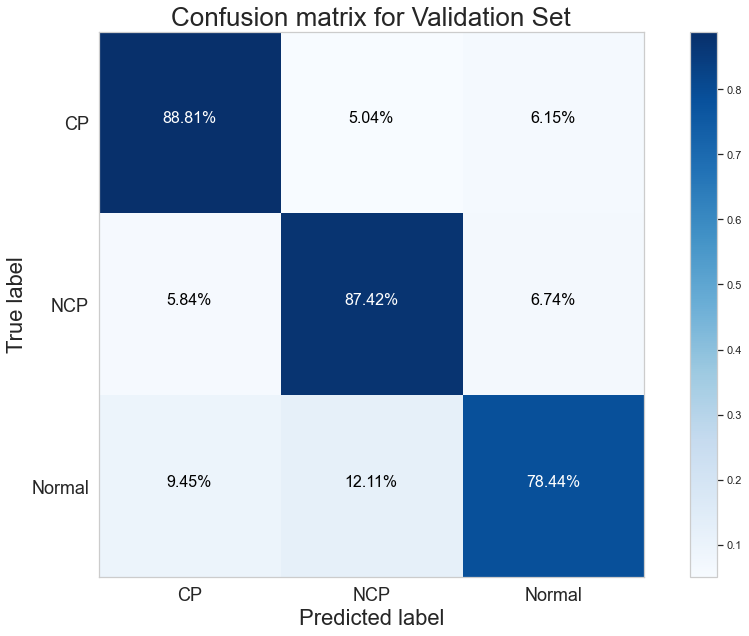

In [50]:
plot_confusion_matrix(
    val_cm,
    classes=class_labels,
    title='Confusion matrix for Validation Set',
    save_to=figures_dir / f"feature_generator_val_conf_matrix_{cnn_model_suffix}.png")

In [51]:
val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(val_true, val_preds, average="weighted")
print(f"Validation F1 Score: {100 * val_f1: .2f}")
print(f"Validation Precision: {100 * val_precision: .2f}")
print(f"Validation Recall: {100 * val_recall: .2f}")

Validation F1 Score:  86.17
Validation Precision:  86.21
Validation Recall:  86.13


In [52]:
train_generator2 = test_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=str(images_input_dir),
    x_col="file",
    y_col="label",
    batch_size=batch_size,
    seed=seed,
    shuffle=False,
    class_mode="categorical",
    target_size=image_target_size)

Found 331286 validated image filenames belonging to 3 classes.


In [53]:
raw_train_preds = loaded_model.predict(train_generator2, steps=STEP_SIZE_TRAIN2 + 1, verbose=1)
raw_train_preds.shape

10353/10353 [==============================] - 2278s 220ms/step


(331286, 3)

In [54]:
train_preds = raw_train_preds.argmax(axis=1)
train_preds[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [55]:
train_generator2.class_indices

{'CP': 0, 'NCP': 1, 'Normal': 2}

In [56]:
train_true = train_generator2.labels
train_true[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Normalized confusion matrix
[[0.87182139 0.0688735  0.05930511]
 [0.0669889  0.84126247 0.09174863]
 [0.12659118 0.1355545  0.73785433]]


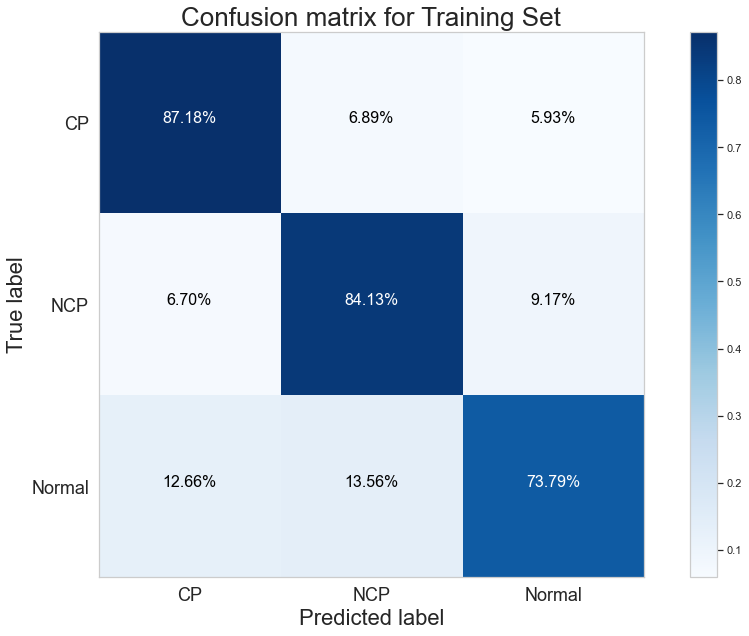

In [66]:
train_cm = confusion_matrix(train_true, train_preds)
plot_confusion_matrix(
    train_cm,
    classes=[k for k in train_generator2.class_indices.keys()],
    title='Confusion matrix for Training Set',
    save_to=figures_dir / f"feature_generator_train_conf_matrix_{cnn_model_suffix}.png")

In [352]:
precision_recall_fscore_support(train_true, train_preds)


(array([0.80084898, 0.87304073, 0.83466738]),
 array([0.94876329, 0.9012732 , 0.54718923]),
 array([0.86855371, 0.88693235, 0.66102517]),
 array([126667, 124961,  79658]))

In [59]:
train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(train_true, train_preds, average="weighted")
print(f"Train F1 Score: {100 * train_f1: .2f}")
print(f"Train Precision: {100 * train_precision: .2f}")
print(f"Train Recall: {100 * train_recall: .2f}")

Train F1 Score:  82.77
Train Precision:  82.75
Train Recall:  82.81


## Evaluate test set

In [60]:
test_df = repo.load("test_df")

In [61]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=str(images_input_dir),
    x_col="file",
    y_col="label",
    batch_size=batch_size,
    seed=seed,
    shuffle=False,
    class_mode="categorical",
    target_size=image_target_size)

Found 40415 validated image filenames belonging to 3 classes.


Normalized confusion matrix
[[0.84405528 0.07469621 0.08124851]
 [0.07366751 0.82525381 0.10107868]
 [0.08669124 0.1648659  0.74844286]]


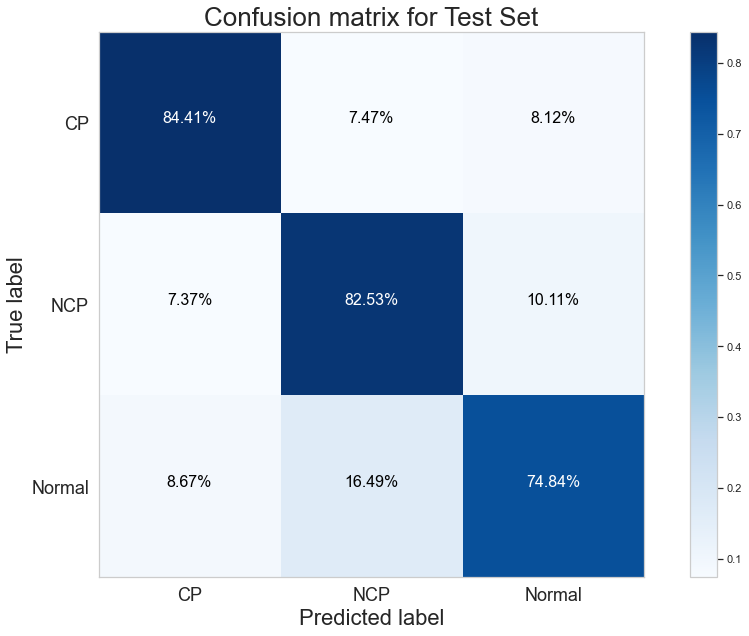

In [65]:
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

raw_test_preds = loaded_model.predict(test_generator, steps=STEP_SIZE_TEST + 1, verbose=1)
raw_test_preds.shape
test_preds = raw_test_preds.argmax(axis=1)
test_preds[:10]
test_generator.class_indices
test_true = test_generator.labels
test_true[:10]
test_cm = confusion_matrix(test_true, test_preds)
plot_confusion_matrix(
    test_cm,
    classes=[k for k in test_generator.class_indices.keys()],
    title='Confusion matrix for Test Set',
    save_to=figures_dir / f"feature_generator_test_conf_matrix_{cnn_model_suffix}.png")

In [64]:
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(test_true, test_preds, average="weighted")
print(f"Test F1 Score: {100 * test_f1: .2f}")
print(f"Test Precision: {100 * test_precision: .2f}")
print(f"Test Recall: {100 * test_recall: .2f}")

Test F1 Score:  82.00
Test Precision:  82.32
Test Recall:  81.81
